# EO Data Processing with the openEO MultiBackendJobManager

In this notebook, we will demonstrate how to use the [MultiBackendJobManager](https://open-eo.github.io/openeo-python-client/cookbook/job_manager.html) to set-up and excecute multiple jobs at once using OpenEO. 

This example will specifically focus on how to a manage a compositing workflow for multiple spatial, evaluated on various spatial locations. 

### Key features

1. Job Tracking: Keep track of jobs their statuses and results across different backends.
2. Error Handling: Customizable handling of job errors and completed jobs.
3. Database Support: Persist job metadata using CSV or Parquet files, allowing you to resume tracking after interruptions.


### Table of Contents

1. [Import Libraries and Define Constants](#import-libraries-and-define-constants)
2. [Creating the Jobs Tracker](#preparing-the-jobs-tracker)
3. [Creating the Job](#creating-the-job)
4. [Running Jobs Using MultiBackendJobManager](#running-jobs-using-multibackendjobmanager)


## Import Libraries and Define Constants

We will start by importing the necessary libraries and defining some constants for our spatial  extents.

In [3]:
import ast
import pandas as pd
import datetime
from typing import Dict, Any
import matplotlib.pyplot as plt
from shapely.geometry import box
import geopandas as gpd
import rasterio
import numpy as np

import openeo
from openeo.extra.job_management import MultiBackendJobManager


# Constants
BASE_SPATIAL_START = {"west": 664000.0, "south": 5611120.0, "crs": "EPSG:32631", "srs": "EPSG:32631"}
SPATIAL_WINDOW_SIZE = 10000  # 10 km in meters
SPATIAL_WINDOW_GAP = 10000   # 10 km gap

## Creating the Jobs Tracker
The `MultiBackendJobManager` operates using a predefined jobs tracker in the shape of a pandas dataframe. In this dataframe, the user must set up with all varying input parameters for each job.

In this example, we will demonstrate the use of the MultiBackendJobManager for managing a compositing workflow conducted on various spatial locations. To automate the creation of our job tracker, we will define a few helper functions. However, note that the job tracker does not need to be set up automatically through code; it can also be created manually and imported as a pandas DataFrame.

### Creating Spatial Extents
The first helper function we will create generates spatial extents based on a specified offset. Each spatial extent represents a 10 km x 10 km window, allowing us to process Earth Observation (EO) data in manageable segments.

In [4]:
def create_spatial_extent(offset_x: int, offset_y: int, base_extent: Dict[str, Any] = BASE_SPATIAL_START) -> Dict[str, Any]:
    """Create a spatial extent dictionary based on an offset for 10 km by 10 km windows."""
    return {
        "west": base_extent["west"] + offset_x * (SPATIAL_WINDOW_SIZE + SPATIAL_WINDOW_GAP),
        "south": base_extent["south"] + offset_y * (SPATIAL_WINDOW_SIZE + SPATIAL_WINDOW_GAP),
        "east": base_extent["west"] + (offset_x + 1) * SPATIAL_WINDOW_SIZE + offset_x * SPATIAL_WINDOW_GAP,
        "north": base_extent["south"] + (offset_y + 1) * SPATIAL_WINDOW_SIZE + offset_y * SPATIAL_WINDOW_GAP,
        "crs": base_extent["crs"],
        "srs": base_extent["srs"]
    }

### Helper Function: Creating the Jobs DataFrame
In this section, we prepare a pandas DataFrame which will form the basis of our job tracker. For each job we wish to run, we include all the relevant input parameters. The function prepare_jobs_df creates this DataFrame, defining spatial extents based on specified offsets. This setup allows for automated management of multiple jobs using the MultiBackendJobManager.

The prepare_jobs_df function generates job configurations for benchmarking. It creates a grid of spatial extents by iterating through a range of offsets.

In [5]:
def prepare_jobs_df(max_offset:int) -> pd.DataFrame:
    """Prepare a DataFrame containing job configurations for benchmarking."""
    jobs = []

    # Create combinations for the spatial grid
    for offset_x in range(max_offset):
        for offset_y in range(max_offset):
            jobs.append({
                "spatial_extent": create_spatial_extent(offset_x, offset_y),
            })

    return pd.DataFrame(jobs)

jobs_df = prepare_jobs_df(max_offset = 3)
print(jobs_df)

                                      spatial_extent
0  {'west': 664000.0, 'south': 5611120.0, 'east':...
1  {'west': 664000.0, 'south': 5631120.0, 'east':...
2  {'west': 664000.0, 'south': 5651120.0, 'east':...
3  {'west': 684000.0, 'south': 5611120.0, 'east':...
4  {'west': 684000.0, 'south': 5631120.0, 'east':...
5  {'west': 684000.0, 'south': 5651120.0, 'east':...
6  {'west': 704000.0, 'south': 5611120.0, 'east':...
7  {'west': 704000.0, 'south': 5631120.0, 'east':...
8  {'west': 704000.0, 'south': 5651120.0, 'east':...


### Visualizing Spatial Extents

Below we visualise how the defined windows cover the area of interest.

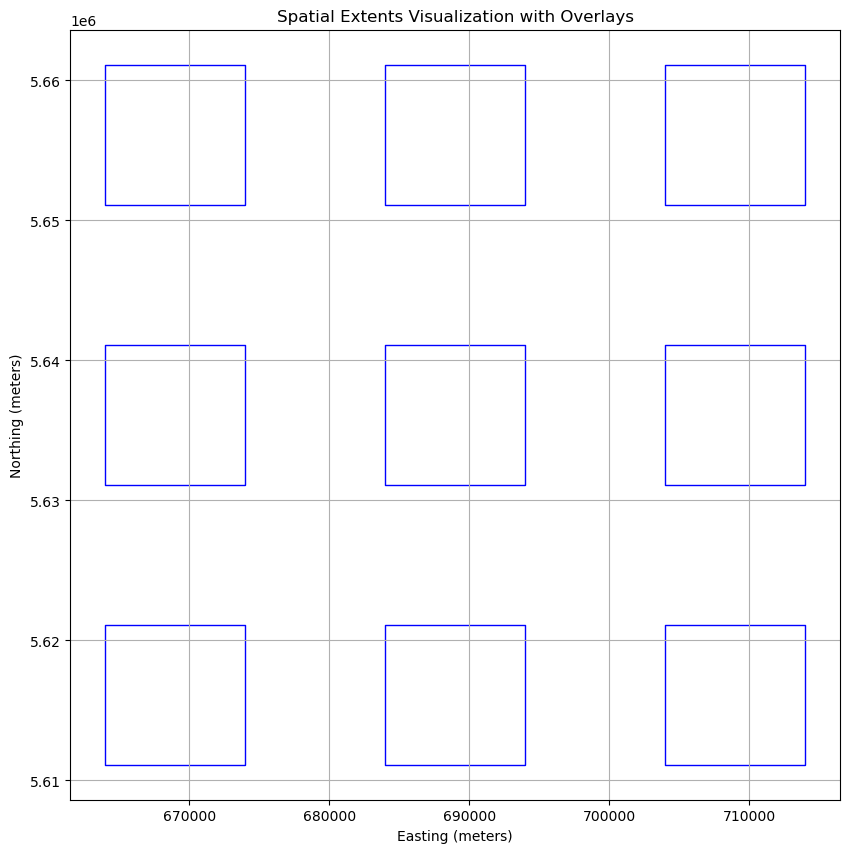

In [6]:
def visualize_spatial_extents(jobs_df: pd.DataFrame):
    """Visualize spatial extents from the given DataFrame and overlay images for finished jobs."""
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Create a GeoDataFrame for spatial extents
    geometries = []
    for index, row in jobs_df.iterrows():
        extent = row["spatial_extent"]
        rectangle = box(extent["west"], extent["south"], extent["east"], extent["north"])
        geometries.append(rectangle)
    
    gdf = gpd.GeoDataFrame(geometry=geometries)
    
    # Plot the spatial extents
    gdf.plot(ax=ax, facecolor='none', edgecolor='blue')
    
   
    plt.xlabel("Easting (meters)")
    plt.ylabel("Northing (meters)")
    plt.title("Spatial Extents Visualization with Overlays")
    plt.grid(True)
    plt.show()

# Example usage
visualize_spatial_extents(jobs_df)



## Creating the Job

Define the `start_job` function, which creates the actual job for each row in our jobs DataFrame.
Do note that the `MultiBackendJobManager` expects a start_joc functionality with the following structure _start_job(row: pd.Series, connection: openeo.Connection, **kwargs)_.

In this example, we dynamically alter the spatial location for each job. However, you can also modify the temporal extent, bands of interest, or job options for each executed job.

Although we implement a process graph for a basic compositing workflow in this example, the `MultiBackendJobManager` can also manage multiple high-computational jobs simultaneously.

In [25]:
def start_job(row: pd.Series, connection: openeo.Connection, **kwargs) -> openeo.BatchJob:
    """Start a new job using the specified row and connection."""
    
    #get the variable parameters from the dataframe
    spatial_extent = row["spatial_extent"]

    #Build the openEO process
    s2_cube = connection.load_collection(
        collection_id="SENTINEL2_L2A",
        spatial_extent=spatial_extent,
        temporal_extent=["2022-06-01","2022-09-01"],
        bands=["B02", "B03", "B04", "SCL"],
        properties={"eo:cloud_cover": lambda x: x.lte(60)}
    )

    # Create weekly composites by taking the mean
    s2_cube = s2_cube.process("mask_scl_dilation", data=s2_cube, scl_band_name="SCL").filter_bands(s2_cube.metadata.band_names[:-1])

    # Create weekly composites by taking the mean
    s2_cube = s2_cube.aggregate_temporal_period(
        period = "month",
        reducer = "mean"
    )

    # Fill gaps in the data using linear interpolation
    s2_cube = s2_cube.apply_dimension(
        dimension = "t",
        process = "array_interpolate_linear"
    )

    s2_cube.save_result(format = "netcdf")
    
    return s2_cube.create_job(
        title='MultiBackendJobManager - Example'
    )


## Running Jobs Using MultiBackendJobManager

With our spatial extents set up, we can now run the jobs using the `MultiBackendJobManager`. This involves defining an output file where the job tracker will store the job statuses and metadata.

### Steps to Run the Jobs:

1. Define the Output File:
   The output file will store the job tracker data, including job statuses and metadata.
   Note that this output file needs a unique name and cannot be overwritten or appended to. 

2. Initialize the MultiBackendJobManager:
   We create an instance of the `MultiBackendJobManager` and add a backend of our choice. This backend will be responsible for executing the jobs.

3. Run Multiple Jobs:
   Use `manager.run_jobs` to create the desired jobs and send them to the backend.
   The output file, defined in step 1, will act as a the live job tracker and contain all the information from the original jobs DataFrame, as well as updates on the actual job statuses.

In [26]:
# Generate a unique output filename
output_file = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '_job_tracker.csv'

# Initiate MultiBackendJobManager 
manager = MultiBackendJobManager()  
connection = openeo.connect(url="openeo.dataspace.copernicus.eu").authenticate_oidc()
manager.add_backend("cdse", connection=connection, parallel_jobs=10)

# Run the jobs
manager.run_jobs(df=jobs_df, start_job=start_job, output_file=output_file)

Authenticated using refresh token.


Notice that once the job has ben finalised the output is downloaded under a dedicated folder named after the job_id.
The output data is saved as a geotiff format.

We can now use this data to visualise the output of our various jobs

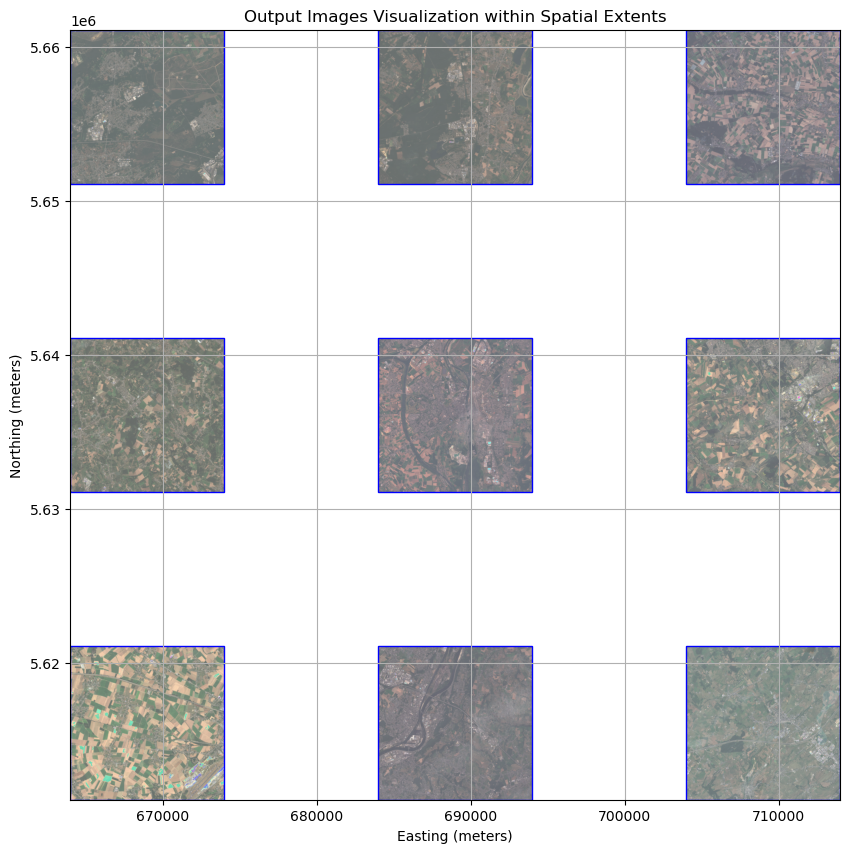

In [47]:


def normalize(array):
    array_min, array_max = array.min(), array.max()
    return ((array - array_min) / (array_max - array_min) * 1024).astype(np.uint8)

def visualize_output(output_df: pd.DataFrame, date:str):
    """Visualize output images for finished jobs within their spatial extents."""
    fig, ax = plt.subplots(figsize=(10, 10))
    x_min, x_max, y_min, y_max = float('inf'), float('-inf'), float('inf'), float('-inf')


    # Plot each output image for finished jobs
    for index, row in output_df.iterrows():
        # Convert the spatial_extent string representation back to a dictionary
        extent = row["spatial_extent"]    
        
        image_path = f"job_{row['id']}/openEO_{date}Z.tif"  # Adjust path based on your setup
        
        
        with rasterio.open(image_path) as src:

            band_blue = src.read(1)
            band_green = src.read(2)
            band_red = src.read(3)

            band_blue = normalize(band_blue)
            band_green = normalize(band_green)
            band_red = normalize(band_red)

            rgb_image = np.dstack((band_red, band_green, band_blue))
            
            # Update axis limits based on current extent
            extent_bounds = [extent["west"], extent["east"], extent["south"], extent["north"]]

            x_min = min(x_min, extent["west"])
            x_max = max(x_max, extent["east"])
            y_min = min(y_min, extent["south"])
            y_max = max(y_max, extent["north"])
            
            # Display the image within its extent
            ax.imshow(rgb_image, extent=extent_bounds, origin='upper', cmap='viridis', alpha=0.6)

            # Draw a box around the extent
            ax.add_patch(plt.Rectangle((extent["west"], extent["south"]),
                                        extent["east"] - extent["west"],
                                        extent["north"] - extent["south"],
                                        linewidth=1, edgecolor='blue', facecolor='none'))

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    plt.xlabel("Easting (meters)")
    plt.ylabel("Northing (meters)")
    plt.title("Output Images Visualization within Spatial Extents")
    plt.grid(True)
    plt.show()

# Example usage
output_df = pd.read_csv(output_file)
# ensure spatial extent is a dictionary
output_df['spatial_extent'] = output_df['spatial_extent'].apply(lambda x: ast.literal_eval(x))
visualize_output(output_df, '2022-07-01')
